[0.7 0.3]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
135.0
0.9101978779701132   4.9951031064404   True
0.7555067155584053   0.2969720364339683   False
0.19282915747648166   1.1910040310500865   True
0.8041280703756853   1.418203217699358   True
0.6588123036351861   0.9133564714412672   True
0.8507028507679764   0.6538532562235112   False
0.768187414818351   0.9463549031775229   True
0.6740219541080228   0.8234032031159185   True
0.9425920279398449   0.6639643327717278   False
0.38266062132210155   0.33609650694724463   False
0.11885515533556201   1.3899607352126484   True
0.44424169934124   0.4958484806225627   True
0.39054563865396996   2.0193223066947503   True
0.6087620322961306   0.6883257223972462   True
0.24442494024639605   1.5401419827435672   True
0.7951064010059872   0.9132620052342587   True
0.6793793921175727   0.7599322600545104   True
0.8364005504056424   1.2870104350701892   True
0.7280077358996907   0.9344584172397068   True
0.16072783383023548   0.891030965

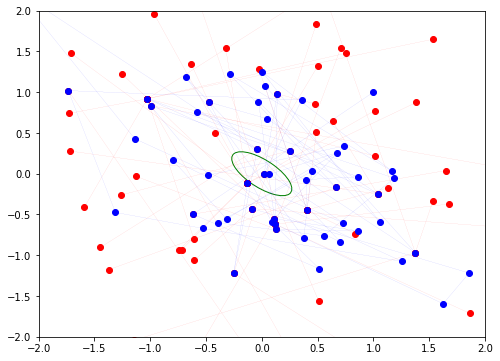

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import math
from scipy.stats import multivariate_normal

sampleNum = 100
# Initial point 
previousSample = np.array([1.0, 1.0])

mu = np.array([0.0, 0.0])
# The covariance matrix has eigenvalue 0.7 for (1, -1) and 0.3 for (1, 1)
# Then, the covariance matrix is ((0.5, -0.2), (-0.2, 0.5))
covarianceMatrix = np.array([[0.5, -0.2], [-0.2, 0.5]])

def q(z, zGiven):
    # Now q(z | zGiven) = q(z) = N(z | 0, I)
    
    #mean = np.array([0.0, 0.0])
    #cov  = np.eye(2)
    
    #print(scipy.stats.multivariate_normal(mean, cov).pdf(z))
    #print(np.exp(-z.dot(z) / 2) / (2 * math.pi))    
    return np.exp(-z.dot(z) / 2) / (2 * math.pi)

def pTilde(z):
    #mean = np.array([0.0, 0.0])
    #cov  = covarianceMatrix
    
    #print(scipy.stats.multivariate_normal(mean, cov).pdf(z))
    #print(np.exp(-(z - mu).dot(np.linalg.inv(covarianceMatrix).dot(z - mu)) / 2) / (2 * math.pi) / (np.linalg.det(covarianceMatrix)**(1/2)))    
    
    return np.exp(-(z - mu).dot(np.linalg.inv(covarianceMatrix).dot(z - mu)) / 2)

class RejectedSample:
    def __init__(self, rejectedPoint, originalPoint):
        self.xs = [rejectedPoint[0], originalPoint[0]]
        self.ys = [rejectedPoint[1], originalPoint[1]]

#Draw a ellipse for p(z)
eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)

print(eigenValues)
print(eigenVectors)

angle = math.atan2(eigenVectors[0][0], eigenVectors[1][0]) / math.pi * 180
print(angle)

covarianceMatrixEllipse = patches.Ellipse(xy=mu, width=eigenValues[0], height=eigenValues[1], angle=angle, fill = False, color = "green")

sampledX = [previousSample[0]]
sampledY = [previousSample[1]]
rejectedSamples = []

for i in range(sampleNum):
    # Step 1 : Draw a sample from q(z | zGiven) = q(z)
    sample = multivariate_normal(np.array([0.0, 0.0]), np.eye(2)).rvs()

    # Step 2 : Calculate r
    r = (pTilde(sample) * q(previousSample, sample)) / (pTilde(previousSample) * q(sample, previousSample))
    
    # Step 3 : Update z (sample)
    threshold = np.random.rand()
    print(threshold, " ", r, " ", min(1, r) > threshold)
    if min(1, r) > threshold:
        # Accepted
        sampledX.append(sample[0])
        sampledY.append(sample[1])
        previousSample = sample
    else:
        # Rejected
        rejectedSamples.append(RejectedSample(sample, previousSample))
    
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.add_patch(covarianceMatrixEllipse)
ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)

for r in rejectedSamples:
    plt.plot(r.xs, r.ys, color = "red", marker = "o", lw = 0.05)

plt.plot(sampledX, sampledY, color = "blue", marker = "o", lw = 0.05)

plt.show()


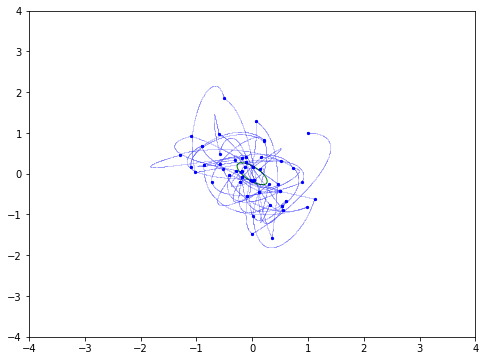

In [3]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import math
from scipy.stats import multivariate_normal

sampleNum = 50
# Initial point 
previousSample = np.array([1.0, 1.0])
epsilon = 0.05
epsilonU = epsilon
epsilonP = epsilon
L = 30

mu = np.array([0.0, 0.0])
# The covariance matrix has eigenvalue 0.7 for (1, -1) and 0.3 for (1, 1)
# Then, the covariance matrix is ((0.5, -0.2), (-0.2, 0.5))
covarianceMatrix = np.array([[0.5, -0.2], [-0.2, 0.5]])

def U(z):
    # U = -ln p~(z)
    return (z - mu).dot(np.linalg.inv(covarianceMatrix).dot(z - mu)) / 2

def K(p):
    return p.dot(p) / 2

def H(z, p):
    return U(z) + K(p)

def dU(z):
    delta = 0.0001
    
    retValue = []
    
    for i in range(len(z)):
        zTmpPlus = np.array(z)
        zTmpMinus = np.array(z)
        
        zTmpPlus[i] = zTmpPlus[i] + delta / 2
        zTmpMinus[i] = zTmpMinus[i] - delta / 2
        retValue.append((U(zTmpPlus) - U(zTmpMinus)) / delta)
    
    return np.array(retValue)

class Path:
    xs = []
    ys = []
    def addPoint(self, point):
        self.xs.append(point[0])
        self.ys.append(point[1])

def calcP(z, p, zStar, pStar):
    return np.exp(-H(zStar, pStar) + H(z, p))

#Draw a ellipse for p(z)
eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)
angle = math.atan2(eigenVectors[0][0], eigenVectors[1][0]) / math.pi * 180
covarianceMatrixEllipse = patches.Ellipse(xy=mu, width=eigenValues[0], height=eigenValues[1], angle=angle, fill = False, color = "green")

sampledX = [previousSample[0]]
sampledY = [previousSample[1]]
sampledPath = []
rejectedX = []
rejectedY = []
rejectedPath = []

for i in range(sampleNum):
    # Step 1 : Sample p.
    p = multivariate_normal(np.array([0.0, 0.0]), np.eye(2)).rvs()
    pInit = np.array(p)

    # Step 2 : calculate z* with leapfrog method
    z = np.array(previousSample)
    path = Path()
    path.addPoint(z)
    
    for j in range(L):
        p = p - epsilonU / 2 * dU(z)
        z = z + epsilonP * p
        p = p - epsilonU / 2 * dU(z)
        path.addPoint(z)
    
    # Step 3 : Calculate r
    r = calcP(previousSample, pInit, z, p)
    
    # Step 4 : Update z (sample)
    threshold = np.random.rand()
#    print(threshold, " ", r, " ", min(1, r) > threshold)
    if min(1, r) > threshold:
        # Accepted
        sampledX.append(z[0])
        sampledY.append(z[1])
        sampledPath.append(path)
        previousSample = z
    else:
        # Rejected
        rejectedX.append(z[0])
        rejectedY.append(z[1])
        rejectedPath.append(path)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.add_patch(covarianceMatrixEllipse)
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)

for p in sampledPath:
    plt.plot(p.xs, p.ys, color = "blue", lw = 0.005)

for p in rejectedPath:
    plt.plot(p.xs, p.ys, color = "red", lw = 0.005)

plt.scatter(sampledX, sampledY, color = "blue", s = 5.0)
plt.scatter(rejectedX, rejectedY, color = "red", s = 5.0)

plt.show()